In [1]:
from import_data_utils import *
sub = 1
cutims, voxels_ROIs_full = import_data_for_sub(sub, path)


(-0.5, 425.5, 425.5, -0.5)

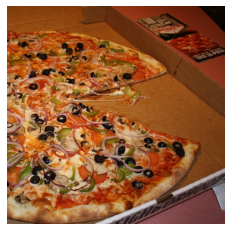

In [24]:
plt.imshow(cutims[113])
plt.axis('off')


### Data categories

In [ ]:
# loding image metadata to find categories
cat_path = "/home/mor/annotations_trainval2017/annotations/"
fname = "instances_train2017"
f = open(cat_path + fname +'.json', "r")
data = json.loads(f.read())

imid = data['annotations'][0]['image_id']
imcat = data['annotations'][0]['category_id']
data.keys()
print([cat['name']  for cat in data['categories'] if cat['id'] == imcat])
# catname = [cat['name'] if cat['id'] == imcat for cat in data['categories']]
# data['categories'][0]
imid

im1= plt.imread(path+"/train2017/train2017/000000" + str(imid) +".jpg")
plt.imshow(im1)

## Drafts

# Loading files & Pre-processing

### beta signals

In [ ]:
# loading beta signals
beta_name1 = 'betas_session01.hdf5'
beta_name2 = 'betas_session02.hdf5'
stim_data_path = '/nsd_stim_info_merged.pkl'
path = '/home/mor/NDS_project/imported_data'
sub_path = path + "/sub"

beta_s1 = np.concatenate((h5py.File(sub_path +"1/"+ beta_name1, "r")["betas"], h5py.File(sub_path +"1/"+ beta_name2, "r")["betas"]), axis=0)
print("the size of the beta is: " + str(beta_s1.shape) + " the dimensions are: trial * Voxel X * Voxel Y * Voxel Z")

# beta_s2 = np.concatenate((h5py.File(sub_path +"2/"+ beta_name1, "r")["betas"], h5py.File(sub_path +"2/"+ beta_name2, "r")["betas"]), axis=0)
# print("the size of the beta is: " + str(beta_s2.shape) + " the dimensions are: trial * Voxel X * Voxel Y * Voxel Z")

### images data

In [ ]:
# loading images data

def import_sub_stim_data(path:str, subnums:list, stim_data:str):
    """
    This function takes the stimulation meta data, which states which subject got which stim and when, and return a
    table with the meta data of the stims of the selected subject got, out of the first 1500 stimulations.
    
    path: str represent the project's files path
    subnums: a list of subject nums, so we filter only rows of stimulation that all the defined subject were experienced
    stim_data: stimulation data file name
    """
    stiminf = pd.read_pickle(path + stim_data)
    for subnum in subnums:
        snum = str(subnum)    
        stiminf = stiminf.loc[(stiminf['subject' + snum] == True) & (stiminf["subject" + snum + "_rep0"] <= 1500)]
    col_rep = ["subject" + str(snum) + "_rep0" for snum in subnums]
    substims = stiminf.filter(["cocoId", "cocoSplit","cropBox"] + col_rep).sort_values(by="subject" + snum + "_rep0")
    substims["zeronum"] =   (12 - substims['cocoId'].fillna('').astype(str).str.len())
    substims["path"] = (substims["cocoSplit"] +"/" + substims["cocoSplit"] + "/" + substims["zeronum"].apply(lambda x: x * '0') + (substims["cocoId"]).astype(str) + ".jpg")
    substims = substims.reset_index()
    return substims

In [ ]:

substims = import_sub_stim_data(path, [1,2], stim_data_path)
sub1stims = import_sub_stim_data(path, [1], stim_data_path)

display(sub1stims)
# type(stim_data)

Here we are extracting the Stimulus data in its pickle format. This structure contains all 8 subjects and al 73K pictures they were presented. 

We filter the first 1500 documented repetitions that subject 1 has underwent. the difference between the repetition number and the number of actual rows is because sum of the repitition did not contain a stimulus (to my understanding) 

We concatenete the string to create the correct file path of each presented picture so we can load it afterwords.

In [ ]:
# displying an example picture 
print("number of train pictures: " + str(len(os.listdir(path + "/train2017/train2017"))))
os.listdir(path)
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im_idx in zip(axs.flat, [1,7,23,46,55,78,99,100]):
    im1_sub1= plt.imread(path+"/"+sub1stims.loc[im_idx]["path"])
    im1_sub1.shape
    ax.imshow(im1_sub1)
    im1_sub1.shape

In [ ]:
# Going over all imageset and cut it

ims_cut_sizes = [1]*len(sub1stims)
ims_cuts = [1]*len(sub1stims)

for i in range(len(sub1stims)):
    im_sub = plt.imread(path+"/"+sub1stims.loc[i]["path"])
    ims_cuts[i] = cut_pic(im_sub, sub1stims.loc[i]["cropBox"])
    ims_cut_sizes[i] = ims_cuts[i].shape
print("Done cutting pics")

In [ ]:
# ROI mappings extracting
def get_roi_vox_data(roi_voxels_fname:str, roi_dict_fname:str) -> (dict, np.ndarray):
    """
       This function converts the voxels-ROI and ROInum-ROIname files to np.ndarray and a dictionary for convinience.
    """
    visROIS = nib.load(roi_voxels_fname)
    unique, counts = np.unique(visROIS.get_fdata(), return_counts=True)
    roi_count = dict(zip(unique, counts))
    print("collecting data from: " + re.search('sub\d/ROIs/(.+?).nii.gz',roi_voxels_fname).group(1))
    print ("relevant voxels: " + str(sum(value for key, value in roi_count.items() if key > 0)))
    print (roi_count)
    roi_legend = open(roi_dict_fname, "r")
    roi_len = roi_legend.read()
    reg_list = re.split('\t +\n|\n', roi_len)[:-1]
    reg_dict = {val[0]:val[2:] for val in reg_list}
    reg_dict[-1] = "unrelated"
    print("categories are: " + str(reg_dict))
    return {'mapping': np.transpose(visROIS.get_fdata(),(2,1,0)), 'legend': reg_dict}

In [ ]:
# ROI voxels extracting- function application
sub1roi_path = "/home/mor/NDS_project/imported_data/sub1/ROIs"
sub2roi_path = "/home/mor/NDS_project/imported_data/sub2/ROIs"

roi_voxels_fnames_s1 = sorted(glob.glob(sub1roi_path +"/*.nii.gz"))
roi_dict_fnames_s1 = sorted(glob.glob(sub1roi_path +"/*.mgz.ctab"))
ROIs_1 = {re.search('1/ROIs/(.+?).nii.gz',vfname).group(1) : get_roi_vox_data(vfname, rfname) for vfname, rfname in zip(roi_voxels_fnames_s1, roi_dict_fnames_s1)}

roi_voxels_fnames_s2 = sorted(glob.glob(sub2roi_path +"/*.nii.gz"))
roi_dict_fnames_s2 = sorted(glob.glob(sub2roi_path +"/*.mgz.ctab"))
ROIs_2 = {re.search('2/ROIs/(.+?).nii.gz',vfname).group(1) : get_roi_vox_data(vfname, rfname) for vfname, rfname in zip(roi_voxels_fnames_s2, roi_dict_fnames_s2)}

In [ ]:
roi_dict_fnames_s2
ROIs_1

ROIs is a dictionaty where the key is the name of the collection of the ROI (eg. visual cortex) and the values are a 2 items dictionary:

mapping- the array of all the voxels and the value of each voxel is its belonging ROI,

legend- a dictionary of ROI number : ROI name

applying function get_roi_vox_data creates a dictionary of a size of the ROI files number we proccess, each element is of size two having the voxels data and the dictionaty.

In [ ]:
def get_voxels_roi(collection, betas, pics_df, df_col):
    """
    This function will return a matrix all the stimului * all the voxels of a certain ROI 
    inputs:
        collection: list of two which is an object of the ROI dict output
        betas: the betas signal
    """
    voxels_ROIS = {}
    ROI_num = len(collection['legend'].keys())
    for i in range(1, ROI_num-1):
        ROI_reg_name = collection['legend'][str(i)]
        filterROI = (collection['mapping'] == i).astype(int)
        betas_reg_roi = np.multiply(betas, np.expand_dims(filterROI, axis=0))
        betas_reg_roi = betas_reg_roi.reshape((len(betas), np.prod(list(betas_reg_roi.shape[1:]))))
        betas_reg_roi = betas_reg_roi[:,~np.all(betas_reg_roi == 0, axis=0)]
        when_pics = list(pics_df[df_col]) # filtering out the beta reps when there was no pic presented
        when_pics = [when-1  for when in when_pics if when <= len(betas)]
        betas_reg_roi = betas_reg_roi[when_pics,:]
        betas_reg_roi = zscore(betas_reg_roi)
        voxels_ROIS[ROI_reg_name] = betas_reg_roi
        print("extracting voxels for: " + ROI_reg_name)
    return voxels_ROIS

In [ ]:
#ROIs for sub1
# voxels_ROIs_full1 = {key : get_voxels_roi(ROIs_1[key], beta_s1, sub1stims, 'subject1_rep0') for key in ROIs_1.keys()}

with open ('/home/mor/NDS_project/imported_datavoxels_ROIs.pkl', 'rb') as f:
    voxels_ROIs_full1 = pkl.load(f)
RDM_fmri_s1 = {}
for area in voxels_ROIs_full.keys():
    RDM_fmri_s1[area] = {}
    for roi in voxels_ROIs_full[area].keys():
        RDM_fmri_s1[area][roi] = 1-np.corrcoef(voxels_ROIs_full[area][roi][:net_lim,:])
    print("Created RDM for: " + str(area))
RDM_fmri_s1['prf-visualrois']['V1v'].shape

## Image filtering

In [ ]:
# pictures cutting
def cut_pic(im, cutbox):
    """
    This function gets the original image, and cuts it according to the matching cropBox given by the metadata table.
    the crop box used to cut the pictures to present them to the subject in the fMRI experiment 
    """
    im_len = im.shape[0]
    im_wid = im.shape[1]
    cut_im = np.ones(im.shape)*128
    cut_im = im[int(im_len*cutbox[0]):int(im_len*(1-cutbox[1])), int(im_wid*cutbox[2]):int(im_wid*(1-cutbox[3])),:]
    return cut_im.astype(int)

## two subs

In [ ]:
RDM_fmri_s1 = {}
for area in voxels_ROIs_full.keys():
    RDM_fmri_s1[area] = {}
    for roi in voxels_ROIs_full[area].keys():
        RDM_fmri_s1[area][roi] = 1-np.corrcoef(voxels_ROIs_full[area][roi][:net_lim,:])
    print("Created RDM for: " + str(area))
    
RDM_fmri_s2 = {}
for area in voxels_ROIs_s2.keys():
    RDM_fmri_s2[area] = {}
    for roi in voxels_ROIs_s2[area].keys():
        RDM_fmri_s2[area][roi] = 1-np.corrcoef(voxels_ROIs_s2[area][roi][:net_lim,:])
    print("Created RDM for: " + str(area))

In [ ]:
# applying for sub2
net_size = 224
batch_size = 64
path = '/home/mor/NDS_project/imported_data'
stim_data_path = '/nsd_stim_info_merged.pkl'
sub_path = path + "/sub"

with open ('/home/mor/NDS_project/imported_data/sub2/beta_s2.pkl', 'rb') as f:
    beta_s2 = pkl.load(f)
print("the size of the beta is: " + str(beta_s2.shape) + " the dimensions are: trial * Voxel X * Voxel Y * Voxel Z")
sub2stims = import_sub_stim_data(path, [2], stim_data_path)
net_lim = (len(sub2stims) // batch_size) * batch_size

#ROIs for sub2
# If saved:
with open ('/home/mor/NDS_project/imported_data/sub2/voxels_ROIs_full2.pkl', 'rb') as f:
    voxels_ROIs_full2 = pkl.load(f)
    
RDM_fmri_2 = {}
for area in voxels_ROIs_full2.keys():
    RDM_fmri_2[area] = {}
    for roi in voxels_ROIs_full2[area].keys():
        RDM_fmri_2[area][roi] = 1-np.corrcoef(voxels_ROIs_full2[area][roi][:net_lim,:])
    print("Created RDM for: " + str(area))

    
# Going over all imageset and cut it
ims_cuts = [1]*len(sub2stims)

for i in range(len(sub2stims)):
    im_sub = plt.imread(path+"/" + sub2stims.loc[i]["path"])
    ims_cuts[i] = cut_pic(im_sub, sub2stims.loc[i]["cropBox"])
print("Done cutting pics")

In [ ]:
plt.hist(visualrois_V1v[:,590])

In [ ]:
# trying to navigate pathes
path = "/home/mor"
print(glob.glob(path+ "/*"))

In [ ]:
# # working with ROIS - Draft
# print("Importing ROI Data")
# visROIS = nib.load(sub1roi_path + "/prf-visualrois.nii.gz")
# roi_legend = open(sub1roi_path +  '/prf-visualrois.mgz.ctab', "r")
# roi_len = roi_legend.read()
# unique, counts = np.unique(visROIS.get_fdata(), return_counts=True)
# roi_count = dict(zip(unique, counts))
# print ("relevant voxels: " + str(sum(value for key, value in roi_count.items() if key > 0)))
# roi_count
# visROIS.shape

In [ ]:
# # working with an example ROI - Chose visualrois_V1v
# # ROI_title = ROIs.keys(0) + ROIs[ROIs.keys(0)][1]
# ROIs_names = list(ROIs.keys())
# reg_ROI_num = 1
# reg_ROI_name = ROIs_names[-1] + "_" + ROIs[ROIs_names[-1]][1][str(reg_ROI_num)]
# filterROI = (ROIs[ROIs_names[-1]][0] == reg_ROI_num).astype(int)
# visualrois_V1v = np.multiply(beta_s1, np.expand_dims(filterROI, axis=0))
# reg_ROI_name

In [ ]:
# type(visualrois_V1v)
# visualrois_V1v = visualrois_V1v.reshape((750, np.prod(list(visualrois_V1v.shape[1:]))))
# visualrois_V1v = visualrois_V1v[:,~np.all(visualrois_V1v == 0, axis=0)]
# when_pics = list(sub1stims['subject1_rep0']) # filtering out the beta reps when there was no pic presented
# when_pics = [when-1  for when in when_pics if when <= 750]
# visualrois_V1v = visualrois_V1v[when_pics,:]
# visualrois_V1v = zscore(visualrois_V1v)

In [ ]:
# a = copy.deepcopy(roi_len)
# reg_list = re.split('\t +\n|\n', roi_len)[:-1]
# reg_dict = {val[0]:val[2:] for val in reg_list}
# reg_dict[-1] = "unrelated"
# reg_dict

In [ ]:
x = input()
print('Hello, ' + x)